## Instructions to run this notebook

In this notebook, we present the comparisons for CS-MNIST: Covaraite shift based colored MNIST.. 
Run all the cells sequentially from top to bottom; we have commented the cells to help the reader.

## Libraries

In [1]:
import tensorflow as tf
import numpy as np
import argparse
import IPython.display as display
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
import pandas as pd
tf.compat.v1.enable_eager_execution()
import cProfile
from sklearn.model_selection import train_test_split
import copy as cp
from sklearn.model_selection import KFold
from datetime import date
import time

In [2]:
from data_construct import * ## contains functions for constructing data 
from IRM_methods import *    ## contains IRM and ERM methods 

## Sample complexity on CS-CMNIST

In [3]:

n_trial =10
n_tr_list = [1000, 5000, 10000, 30000, 60000] # list of training sample sizes

k=0
K = len(n_tr_list)
ERM_model_acc = np.zeros((K,n_trial))
ERM_model_acc_nb = np.zeros((K,n_trial))
IRM_model_acc = np.zeros((K,n_trial))
IRM_model_acc_v = np.zeros((K,n_trial))
IRM_model_ind_v = np.zeros((K,n_trial))

ERM_model_acc1 = np.zeros((K,n_trial))
ERM_model_acc1_nb = np.zeros((K,n_trial))
IRM_model_acc1 = np.zeros((K,n_trial))
IRM_model_acc1_v = np.zeros((K,n_trial))
IRM_model_ind_v = np.zeros((K,n_trial))

ERM_model_acc_av = np.zeros(K)
ERM_model_acc_av_nb = np.zeros(K)
IRM_model_acc_av = np.zeros(K)
IRM_model_acc_av_v = np.zeros(K)


ERM_model_acc_av1 = np.zeros(K)
ERM_model_acc_av1_nb = np.zeros(K)
IRM_model_acc_av1 = np.zeros(K)
IRM_model_acc_av1_v = np.zeros(K)

list_params = []
for n_tr in n_tr_list:
    print ("tr" + str(n_tr))
    t_start = time.time()
    for trial in range(n_trial):
        print ("trial " + str(trial))
        n_e=2
        p_color_list = [0.2, 0.1]
        p_label_list = [0.25]*n_e
        D = assemble_data_mnist_sb(n_tr) # initialize mnist digits data object

        D.create_training_data(n_e, p_color_list, p_label_list) # creates the training environments

        p_label_test = 0.25 # probability of switching pre-label in test environment
        p_color_test = 0.9  # probability of switching the final label to obtain the color index in test environment

        D.create_testing_data(p_color_test, p_label_test, n_e)  # sets up the testing environment
        (num_examples_environment,length, width, height) = D.data_tuple_list[0][0].shape # attributes of the data
        num_classes = len(np.unique(D.data_tuple_list[0][1])) # number of classes in the data

        model_erm =  keras.Sequential([
                keras.layers.Flatten(input_shape=(length,width,height)),
                keras.layers.Dense(390, activation = 'relu',kernel_regularizer=keras.regularizers.l2(0.0011)),
                keras.layers.Dense(390, activation='relu',kernel_regularizer=keras.regularizers.l2(0.0011)),
                keras.layers.Dense(2, activation='softmax')
        ])
        
        num_epochs = 100
        batch_size = 512
        learning_rate = 4.9e-4
        erm_model1 = standard_erm_model(model_erm, num_epochs, batch_size, learning_rate)
        erm_model1.fit(D.data_tuple_list)
        erm_model1.evaluate(D.data_tuple_test)
        print ("Training accuracy:" + str(erm_model1.train_acc))
        print ("Testing accuracy:" + str(erm_model1.test_acc))
        
        ERM_model_acc[k][trial] = erm_model1.test_acc
        ERM_model_acc1[k][trial] = erm_model1.train_acc


        gamma_list = [10000, 33000, 66000,100000.0]
        index=0
        best_err = 1e6
        train_list =[]
        val_list = []
        test_list = []
        for gamma_new in gamma_list:

            model_irm = keras.Sequential([
                                keras.layers.Flatten(input_shape=(length,width,height)),
                                keras.layers.Dense(390, activation = 'relu',kernel_regularizer=keras.regularizers.l2(0.0011)),
                                keras.layers.Dense(390, activation='relu',kernel_regularizer=keras.regularizers.l2(0.0011)),
                                keras.layers.Dense(num_classes)
                        ])
            batch_size       = 512
            steps_max        = 1000
            steps_threshold  = 190  ## threshold after which gamma_new is used
            learning_rate    = 4.9e-4


            irm_model1 = irm_model(model_irm, learning_rate, batch_size, steps_max, steps_threshold, gamma_new)
            irm_model1.fit(D.data_tuple_list)
            irm_model1.evaluate(D.data_tuple_test)
            error_val = 1-irm_model1.val_acc
            train_list.append(irm_model1.train_acc)
            val_list.append(irm_model1.val_acc)
            test_list.append(irm_model1.test_acc)
            if(error_val<best_err):
                index_best =index
                best_err = error_val
            index= index+1

        print ("Training accuracy:" + str(train_list[index_best]))
        print ("Validation accuracy:" + str(val_list[index_best]))
        print ("Testing accuracy:" + str(test_list[index_best]))

        IRM_model_acc_v[k][trial]  = test_list[index_best]
        IRM_model_acc1_v[k][trial] = train_list[index_best]
        IRM_model_ind_v[k][trial]  = index_best


    IRM_model_acc_av_v[k] = np.mean(IRM_model_acc_v[k])
    list_params.append([n_tr,"IRMv_test", np.mean(IRM_model_acc_v[k]),np.std(IRM_model_acc_v[k])])

    ERM_model_acc_av[k] = np.mean(ERM_model_acc[k])
    list_params.append([n_tr,"ERM_test", np.mean(ERM_model_acc[k]),np.std(ERM_model_acc[k])])


    IRM_model_acc_av1_v[k] = np.mean(IRM_model_acc1_v[k])
    list_params.append([n_tr,"IRMv_train", np.mean(IRM_model_acc1_v[k]),np.std(IRM_model_acc1_v[k])])
    
    ERM_model_acc_av1[k] = np.mean(ERM_model_acc1[k])
    list_params.append([n_tr, "ERM_train", np.mean(ERM_model_acc1[k]),np.std(ERM_model_acc1[k])])


    k=k+1

    t_end = time.time()
    print("total time: " + str(t_end-t_start))
    


results = pd.DataFrame(list_params, columns= ["Sample","Method", "Performance", "Sdev"])
ideal_error = np.zeros(5)

print ("end")

tr1000
trial 0
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
533/533 [==============================] - 0s 839us/sample - loss: 1.8487 - acc: 0.5291
Epoch 2/100
533/533 [==============================] - 0s 51us/sample - loss: 1.5220 - acc: 0.8649
Epoch 3/100
533/533 [==============================] - 0s 59us/sample - loss: 1.5198 - acc: 0.8649
Epoch 4/100
533/533 [==============================] - 0s 51us/sample - loss: 1.5119 - acc: 0.8649
Epoch 5/100
533/533 [==============================] - 0s 52us/sample - loss: 1.4440 - acc: 0.8649
Epoch 6/100
533/533 [==============================] - 0s 61us/sample - loss: 1.3561 - acc: 0.8649
Epoch 7/100
533/533 [==============================] - 0s 67us/sample - loss: 1.2892 - acc: 0.8649
Epoch 8/100
533/533 [==============================] - 0s 74us/sample - loss: 1.2442 - acc: 0.8743
Epoch 9/100
533/533 [==============================] - 0s 65us/sample - loss: 1.2058 - acc: 0.8874

533/533 [==============================] - 0s 55us/sample - loss: 0.3330 - acc: 1.0000
Epoch 80/100
533/533 [==============================] - 0s 56us/sample - loss: 0.3300 - acc: 1.0000
Epoch 81/100
533/533 [==============================] - 0s 63us/sample - loss: 0.3269 - acc: 1.0000
Epoch 82/100
533/533 [==============================] - 0s 58us/sample - loss: 0.3239 - acc: 1.0000
Epoch 83/100
533/533 [==============================] - 0s 52us/sample - loss: 0.3208 - acc: 1.0000
Epoch 84/100
533/533 [==============================] - 0s 61us/sample - loss: 0.3180 - acc: 1.0000
Epoch 85/100
533/533 [==============================] - 0s 56us/sample - loss: 0.3155 - acc: 1.0000
Epoch 86/100
533/533 [==============================] - 0s 52us/sample - loss: 0.3128 - acc: 1.0000
Epoch 87/100
533/533 [==============================] - 0s 50us/sample - loss: 0.3097 - acc: 1.0000
Epoch 88/100
533/533 [==============================] - 0s 57us/sample - loss: 0.3068 - acc: 1.0000
Epoch 89/100


2507/2507 [==============================] - 0s 62us/sample - loss: 0.1104 - acc: 1.0000
Epoch 59/100
2507/2507 [==============================] - 0s 62us/sample - loss: 0.1073 - acc: 1.0000
Epoch 60/100
2507/2507 [==============================] - 0s 50us/sample - loss: 0.1045 - acc: 1.0000
Epoch 61/100
2507/2507 [==============================] - 0s 63us/sample - loss: 0.1017 - acc: 1.0000
Epoch 62/100
2507/2507 [==============================] - 0s 47us/sample - loss: 0.0991 - acc: 1.0000
Epoch 63/100
2507/2507 [==============================] - 0s 60us/sample - loss: 0.0964 - acc: 1.0000
Epoch 64/100
2507/2507 [==============================] - 0s 49us/sample - loss: 0.0939 - acc: 1.0000
Epoch 65/100
2507/2507 [==============================] - 0s 59us/sample - loss: 0.0914 - acc: 1.0000
Epoch 66/100
2507/2507 [==============================] - 0s 48us/sample - loss: 0.0891 - acc: 1.0000
Epoch 67/100
2507/2507 [==============================] - 0s 56us/sample - loss: 0.0870 - acc: 

4961/4961 [==============================] - 0s 64us/sample - loss: 0.1004 - acc: 1.0000
Epoch 37/100
4961/4961 [==============================] - 0s 58us/sample - loss: 0.0962 - acc: 1.0000
Epoch 38/100
4961/4961 [==============================] - 0s 63us/sample - loss: 0.0921 - acc: 1.0000
Epoch 39/100
4961/4961 [==============================] - 0s 57us/sample - loss: 0.0882 - acc: 1.0000
Epoch 40/100
4961/4961 [==============================] - 0s 63us/sample - loss: 0.0844 - acc: 1.0000
Epoch 41/100
4961/4961 [==============================] - 0s 70us/sample - loss: 0.0811 - acc: 1.0000
Epoch 42/100
4961/4961 [==============================] - 0s 56us/sample - loss: 0.0781 - acc: 1.0000
Epoch 43/100
4961/4961 [==============================] - 0s 66us/sample - loss: 0.0750 - acc: 1.0000
Epoch 44/100
4961/4961 [==============================] - 0s 60us/sample - loss: 0.0723 - acc: 1.0000
Epoch 45/100
4961/4961 [==============================] - 0s 55us/sample - loss: 0.0692 - acc: 

15122/15122 [==============================] - 1s 76us/sample - loss: 0.1257 - acc: 0.9977
Epoch 15/100
15122/15122 [==============================] - 1s 77us/sample - loss: 0.1150 - acc: 0.9987
Epoch 16/100
15122/15122 [==============================] - 1s 78us/sample - loss: 0.1055 - acc: 0.9989
Epoch 17/100
15122/15122 [==============================] - 1s 75us/sample - loss: 0.0965 - acc: 0.9993
Epoch 18/100
15122/15122 [==============================] - 1s 83us/sample - loss: 0.0893 - acc: 0.9992
Epoch 19/100
15122/15122 [==============================] - 1s 74us/sample - loss: 0.0840 - acc: 0.9989
Epoch 20/100
15122/15122 [==============================] - 1s 72us/sample - loss: 0.0792 - acc: 0.9991
Epoch 21/100
15122/15122 [==============================] - 1s 78us/sample - loss: 0.0729 - acc: 0.9994
Epoch 22/100
15122/15122 [==============================] - 1s 78us/sample - loss: 0.0680 - acc: 0.9998
Epoch 23/100
15122/15122 [==============================] - 1s 86us/sample - 

15122/15122 [==============================] - 1s 74us/sample - loss: 0.0163 - acc: 1.0000
Epoch 93/100
15122/15122 [==============================] - 1s 79us/sample - loss: 0.0165 - acc: 1.0000
Epoch 94/100
15122/15122 [==============================] - 1s 77us/sample - loss: 0.0174 - acc: 0.9999
Epoch 95/100
15122/15122 [==============================] - 1s 76us/sample - loss: 0.0185 - acc: 0.9999
Epoch 96/100
15122/15122 [==============================] - 1s 77us/sample - loss: 0.0207 - acc: 0.9987
Epoch 97/100
15122/15122 [==============================] - 1s 80us/sample - loss: 0.0340 - acc: 0.9940
Epoch 98/100
15122/15122 [==============================] - 1s 73us/sample - loss: 0.0388 - acc: 0.9931
Epoch 99/100
15122/15122 [==============================] - 1s 81us/sample - loss: 0.0402 - acc: 0.9935
Epoch 100/100
15122/15122 [==============================] - 1s 70us/sample - loss: 0.0328 - acc: 0.9968
Training accuracy:0.9990742206573486
Testing accuracy:0.9089260697364807
Tra

30165/30165 [==============================] - 2s 57us/sample - loss: 0.0179 - acc: 1.0000
Epoch 69/100
30165/30165 [==============================] - 2s 55us/sample - loss: 0.0195 - acc: 0.9997
Epoch 70/100
30165/30165 [==============================] - 2s 53us/sample - loss: 0.0323 - acc: 0.9952
Epoch 71/100
30165/30165 [==============================] - 2s 57us/sample - loss: 0.0302 - acc: 0.9967
Epoch 72/100
30165/30165 [==============================] - 2s 59us/sample - loss: 0.0360 - acc: 0.9944
Epoch 73/100
30165/30165 [==============================] - 2s 57us/sample - loss: 0.0308 - acc: 0.9971
Epoch 74/100
30165/30165 [==============================] - 2s 54us/sample - loss: 0.0277 - acc: 0.9985
Epoch 75/100
30165/30165 [==============================] - 2s 54us/sample - loss: 0.0246 - acc: 0.9990
Epoch 76/100
30165/30165 [==============================] - 2s 58us/sample - loss: 0.0211 - acc: 0.9999
Epoch 77/100
30165/30165 [==============================] - 2s 51us/sample - 

## Plot the results

(-0.01, 0.8)

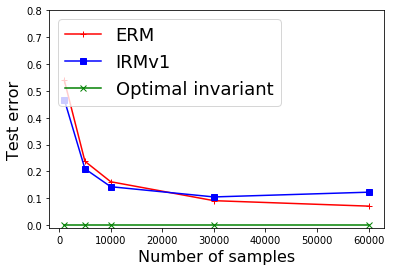

In [4]:
plt.figure()
plt.xlabel("Number of samples", fontsize=16)
plt.ylabel("Test error", fontsize=16)
plt.plot(n_tr_list, 1-ERM_model_acc_av, "-r", marker="+", label="ERM")
plt.plot(n_tr_list, 1-IRM_model_acc_av_v, "-b", marker="s",label="IRMv1")
plt.plot(n_tr_list, ideal_error, "-g", marker="x", label="Optimal invariant")
plt.legend(loc="upper left", fontsize=18)
plt.ylim(-0.01,0.8)

In [5]:
results

,Sample,Method,Performance,Sdev
0,1000,IRMv_test,0.532615,0.0
1,1000,ERM_test,0.460476,0.0
2,1000,IRMv_train,1.000000,0.0
3,1000,ERM_train,1.000000,0.0
4,5000,IRMv_test,0.790206,0.0
5,5000,ERM_test,0.762193,0.0
6,5000,IRMv_train,1.000000,0.0
7,5000,ERM_train,1.000000,0.0
8,10000,IRMv_test,0.856914,0.0
9,10000,ERM_test,0.838451,0.0
